In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import comb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Utils

#### plot_sample_horiz

In [2]:
def plot_sample_horiz(sample, null=None, x_lim=None, output_filename=None, title=None):
    
    # Set up plot
    sns.set(style='whitegrid')
    fontsize = 24
    font = {'family': 'DejaVu Sans',
            'weight': 'normal',
            'size': fontsize}
    plt.rc('font', **font)
    alpha_plot = 0.5

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 2))
    
    # Plot distribution of bootstrap means
    sns.stripplot(x=sample,
                  size=7, color='b', orient='h',
                  ax=ax);
    
    # Increase height
    y_lim = list(ax.get_ylim())
    y_lim[0] = y_lim[0] + y_lim[0] * 0.1
    y_lim[1] = y_lim[1] + y_lim[1] * 0.1
    ax.set_ylim(y_lim);
    
    if x_lim:
        ax.set_xlim(x_lim);        
    
    # Add null
    if null:
        ax.axvline(x=null, 
                   color='b', linewidth=2, linestyle=':')
    
    # Add mean
    sample_mean = np.mean(sample)
    ax.axvline(x=sample_mean, 
               color='k', linewidth=2, linestyle='-')
    
    # Add median
    sample_median = np.median(sample)
    ax.axvline(x=sample_median, 
               color='k', linewidth=2, linestyle='--')

    # Ticks
    plt.setp(ax.get_xticklabels(), fontsize=0.7 * fontsize, verticalalignment='top');
    
    if title:
        ax.set_title(title)

    
    if output_filename:
        f.savefig(output_filename, dpi=f.dpi * 3, bbox_inches='tight')

#### add_ci_mean

In [3]:
def add_ci_mean(ax, sample_mean, sample_std, ci, color, alpha, fontsize, invert=False):
    
    # Fill area between CI
    dist = ax.lines[0]
    dist_y = dist.get_ydata()
    dist_x = dist.get_xdata()
    linewidth = dist.get_linewidth()
    
    x_idx_low = np.argmin(np.abs(dist_x - ci[0]))
    x_idx_high = np.argmin(np.abs(dist_x - ci[1]))
    x_ci = dist_x[x_idx_low:x_idx_high]
    y_ci = dist_y[x_idx_low:x_idx_high]
    
    ax.fill_between(x_ci, 0, y_ci, facecolor=color, alpha=alpha)
    
    # Add vertical lines of CI
    ax.vlines(x=ci[0], ymin=0., ymax=y_ci[0], color=color, linewidth=linewidth, label='ci_low')
    ax.vlines(x=ci[1], ymin=0., ymax=y_ci[-1], color=color, linewidth=linewidth, label='ci_high')
    
    # Add annotations
    bbox_props = dict(boxstyle='round, pad=0.4', fc='w', ec='k', lw=2)
    
    if invert:
        ha_l = 'right'
        ha_u = 'left'
    else:
        ha_l = 'left'
        ha_u = 'right'
    ax.text(ci[0], 0., s='L = {:.4f}'.format(ci[0]), ha=ha_l, va='bottom', fontsize=fontsize,
            bbox=bbox_props)
    ax.text(ci[1], 0., s='U = {:.4f}'.format(ci[1]), ha=ha_u, va='bottom', fontsize=fontsize,
            bbox=bbox_props)
    
    # Add vertical line of sample mean
    x_idx_mean = np.argmin(np.abs(dist_x - sample_mean))
    ax.vlines(x=sample_mean, ymin=0., ymax=dist_y[x_idx_mean], color='k', linewidth=linewidth)
    
    # Add annotation of sample mean
    bbox_props = dict(boxstyle='round, pad=0.4', fc='w', ec='k', lw=2)
    
    ax.text(sample_mean, 0.6 * dist_y[x_idx_mean], s='Sample mean = {:.4f}'.format(sample_mean), 
            ha='center', va='center', fontsize=fontsize,
            bbox=bbox_props)
    
    # Add SD
    bbox_props = dict(boxstyle='darrow, pad=0.4', fc='w', ec='k', lw=2)
    
    ax.text(sample_mean, 0.4 * dist_y[x_idx_mean], s='SD = {:.4f} = SEM'.format(sample_std), 
            ha='center', va='center', fontsize=fontsize,
            bbox=bbox_props)

#### add_null_pval

In [4]:
def add_null_pval(ax, null, color, alpha, fontsize):
    
    # Fill area between CI
    dist = ax.lines[0]
    dist_y = dist.get_ydata()
    dist_x = dist.get_xdata()
    linewidth = dist.get_linewidth()
    
    x_idx_null = np.argmin(np.abs(dist_x - null))
    if x_idx_null >= (len(dist_x) / 2.):
        x_pval = dist_x[x_idx_null:]
        y_pval = dist_y[x_idx_null:]
    else:
        x_pval = dist_x[:x_idx_null]
        y_pval = dist_y[:x_idx_null]
    
    ax.fill_between(x_pval, 0, y_pval, facecolor=color, alpha=alpha)
       
    # Add vertical lines of null
    dist = ax.lines[0]
    linewidth = dist.get_linewidth()
    y_max = ax.get_ylim()[1]
    ax.vlines(x=null, ymin=0., ymax=y_max, color='k', linewidth=linewidth, linestyles='dotted')
    
    # Add annotations
    bbox_props = dict(boxstyle='round, pad=0.4', fc='w', ec='k', lw=2)
    
    ax.text(null, 0.75 * y_max, s='Null hypothesis = {:.1f}'.format(null), ha='center', va='center', 
            fontsize=fontsize, bbox=bbox_props)

#### plot_bootstrap_distr

In [5]:
def plot_bootstrap_distr(bs_means, alpha, color_ci, null=None, color_pval=None, x_lim=None, output_filename=None):
    
    # Compute results from bootstrap
    q_low = (1. - alpha) / 2.
    q_high = 1. - q_low
    ci = np.quantile(bs_means, [q_low, q_high])
    sample_mean = np.mean(bs_means)
    sample_std = np.std(bs_means)
    
    if null is not None and color_pval is not None:
        pval_flag = True
        pval = np.min([[np.mean(bs_means > null), np.mean(bs_means < null)]]) * 2
    else:
        pval_flag = False
    
    # Set up plot
    sns.set(style='whitegrid')
    fontsize = 24
    font = {'family': 'DejaVu Sans',
            'weight': 'normal',
            'size': fontsize}
    plt.rc('font', **font)
    alpha_plot = 0.5

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(30, 12))
    
    # Plot distribution of bootstrap means
    sns.kdeplot(bs_means,
                color='b', linewidth=5, gridsize=1000,
                ax=ax);

    y_lim = ax.get_ylim()

    # Change spines
    sns.despine(left=True, bottom=True)

    # Annotations
    add_ci_mean(ax, sample_mean, sample_std, ci, color=color_ci, alpha=alpha_plot, fontsize=fontsize)
    
    if pval_flag:
        add_null_pval(ax, null, color=color_pval, alpha=alpha_plot, fontsize=fontsize)

    # Legend
    ci_patch = mpatches.Patch(facecolor=color_ci, edgecolor=None, alpha=alpha_plot,
                              label='{:d} % confidence interval'.format(int(100 * alpha)))
    
    if pval_flag:
        if pval == 0.:
            pval_patch = mpatches.Patch(facecolor=color_pval, edgecolor=None, alpha=alpha_plot,
                                        label='P value / 2 = {:.1f}'.format(pval / 2.))
        elif np.around(pval / 2., decimals=4) > 0.0000:
            pval_patch = mpatches.Patch(facecolor=color_pval, edgecolor=None, alpha=alpha_plot,
                                        label='P value / 2 = {:.4f}'.format(pval / 2.))
        else:
            pval_patch = mpatches.Patch(facecolor=color_pval, edgecolor=None, alpha=alpha_plot,
                                        label='P value / 2 < $10^{}$'.format(np.ceil(np.log10(pval / 2.))))

        leg = ax.legend(handles=[ci_patch, pval_patch], ncol=1, loc='upper right', 
                        frameon=True, framealpha=1., title='', 
                        fontsize=fontsize, columnspacing=1.0, labelspacing=0.2, markerfirst=True)
    else:
        leg = ax.legend(handles=[ci_patch], ncol=1, loc='upper right', 
                        frameon=True, framealpha=1., title='', 
                        fontsize=fontsize, columnspacing=1.0, labelspacing=0.2, markerfirst=True)
        
    plt.setp(leg.get_title(), fontsize=fontsize, 
             horizontalalignment='left')

    # Set X-label
    ax.set_xlabel('Bootstrap means',
                  rotation=0, 
                  fontsize=fontsize,
                  labelpad=10.);

    # Set Y-label
    ax.set_ylabel('Density',
                  rotation=90, 
                  fontsize=fontsize,
                  labelpad=10.);

    # Ticks
    plt.setp(ax.get_xticklabels(), fontsize=0.8 * fontsize, verticalalignment='top');
    plt.setp(ax.get_yticklabels(), fontsize=0.8 * fontsize);

    ax.set_ylim(y_lim);
    
    if x_lim:
        ax.set_xlim(x_lim); 
    
    if output_filename:
        f.savefig(output_filename, dpi=f.dpi * 3, bbox_inches='tight')

## Colour palette

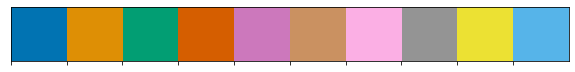

In [6]:
sns.palplot(sns.color_palette('colorblind'))

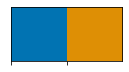

In [7]:
palette_colorblind = sns.color_palette('colorblind')
color_cat1 = palette_colorblind[0]
color_cat2 = palette_colorblind[1]
sns.palplot([color_cat1, color_cat2])

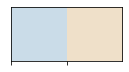

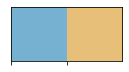

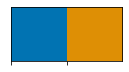

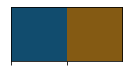

In [8]:
palette_lightest = [sns.light_palette(color_cat1, n_colors=20)[3], 
                    sns.light_palette(color_cat2, n_colors=20)[3]]
palette_light = [sns.light_palette(color_cat1, n_colors=3)[1], 
                 sns.light_palette(color_cat2, n_colors=3)[1]]
palette_medium = [color_cat1, color_cat2]
palette_dark = [sns.dark_palette(color_cat1, n_colors=3)[1], 
                sns.dark_palette(color_cat2, n_colors=3)[1]]

palette_cat1 = [palette_lightest[0], palette_light[0], palette_medium[0], palette_dark[0]]
palette_cat2 = [palette_lightest[1], palette_light[1], palette_medium[1], palette_dark[1]]

color_cat1_light = palette_light[0]
color_cat2_light = palette_light[1]

sns.palplot(palette_lightest)
sns.palplot(palette_light)
sns.palplot(palette_medium)
sns.palplot(palette_dark)

## Data

In [9]:
data = {'beer': [27, 19, 20, 20, 23, 17, 21, 24, 31, 26, 28, 20, 27, 19, 25, 31, 24, 28, 24, 29, 21,
                 21, 18, 27, 20],
        'water': [21, 19, 13, 22, 15, 22, 15, 22, 20, 12, 24, 24, 21, 19, 18, 16, 23, 20]}

## Visualise the data

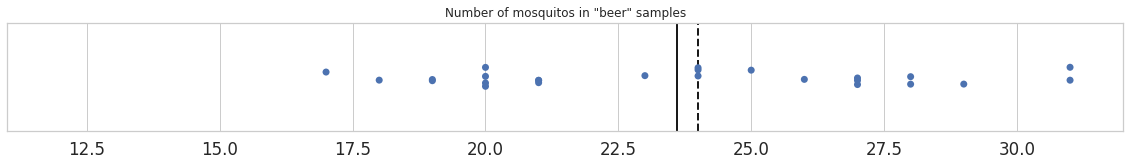

In [10]:
plot_sample_horiz(data['beer'], null=None, x_lim=[11, 32],
                  output_filename='./img/mosquitos_sample_beer.png', 
                  title='Number of mosquitos in "beer" samples')

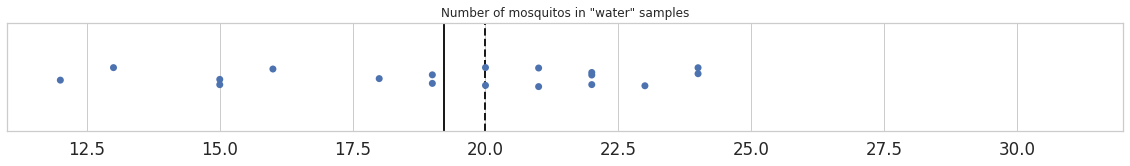

In [11]:
plot_sample_horiz(data['water'], null=None, x_lim=[11, 32],
                  output_filename='./img/mosquitos_sample_water.png', 
                  title='Number of mosquitos in "water" samples')

## Bootstrap (for group comparisons)

We sample observations with replacement independently for each group

In [12]:
n_bs_samples = 100000
alpha = 0.95

#### Run simulations

In [13]:
bs_means = {'beer': np.zeros(n_bs_samples),
            'water': np.zeros(n_bs_samples)}
bs_norm_diff = np.zeros(n_bs_samples)

for idx, s in enumerate(range(n_bs_samples)):
    # Sample with replacement
    bs_sample_beer = np.random.choice(data['beer'], size=len(data['beer']), replace=True)
    bs_sample_water = np.random.choice(data['water'], size=len(data['water']), replace=True)
    
    # Store means
    mean_beer = np.mean(bs_sample_beer)
    mean_water = np.mean(bs_sample_water)
    bs_means['beer'][idx] = mean_beer
    bs_means['water'][idx] = mean_water
            
    # Store normalised difference of the means
    bs_norm_diff[idx] = (mean_beer - mean_water) / (mean_beer + mean_water)

### Plot

#### Bootstrap sample distribution of the mean in the beer group

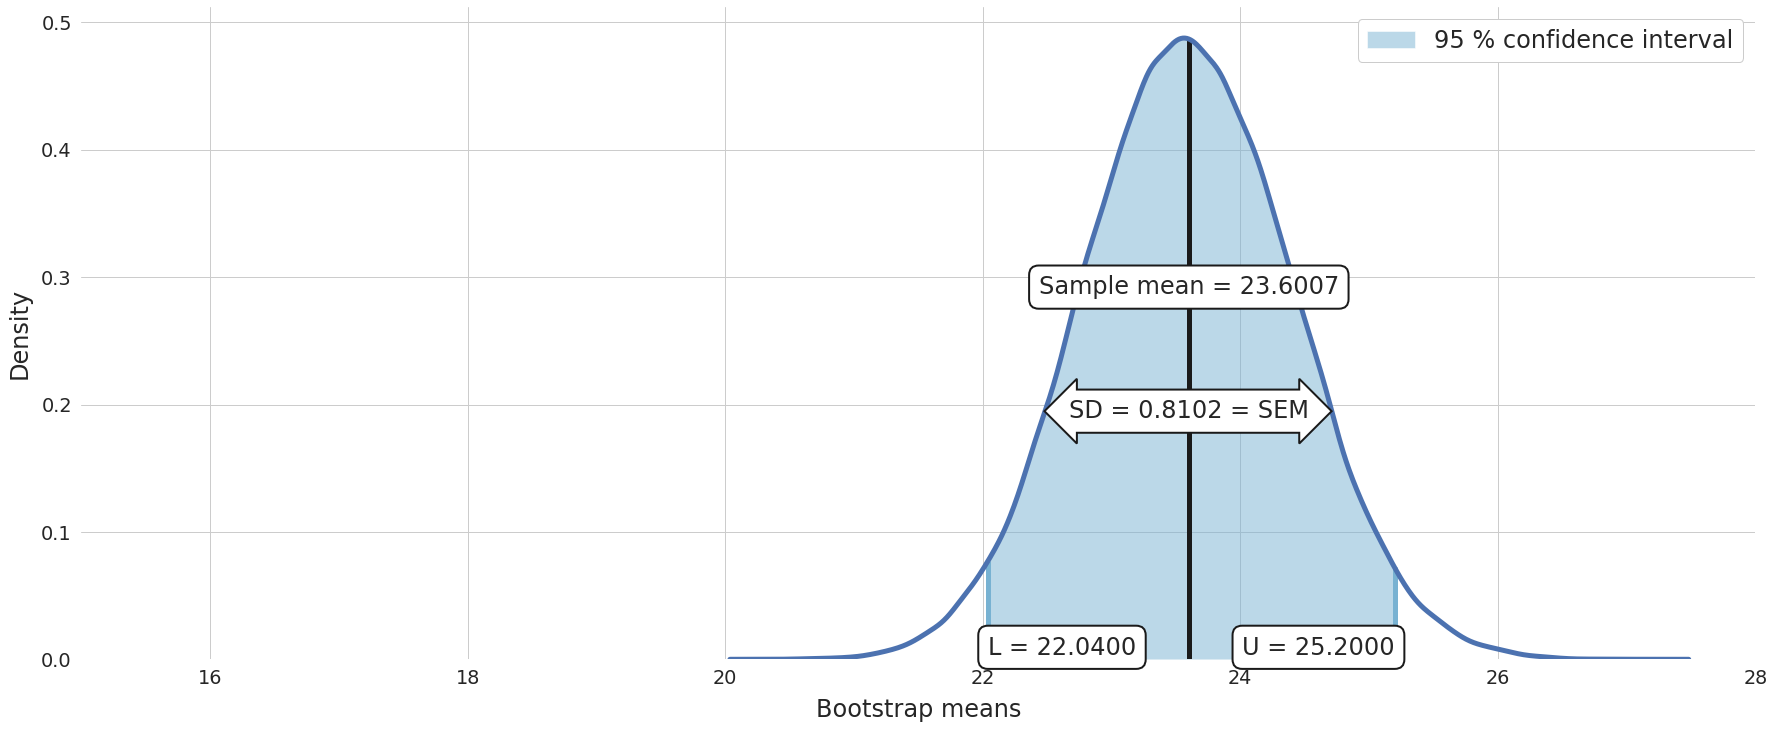

In [14]:
plot_bootstrap_distr(bs_means['beer'], alpha=alpha, color_ci=color_cat1_light, 
                     null=None, color_pval=None, x_lim=[15., 28.], 
                     output_filename='./img/mosquitos_bootstrap_distr_beer.png')

#### Bootstrap sample distribution of the mean in the water group

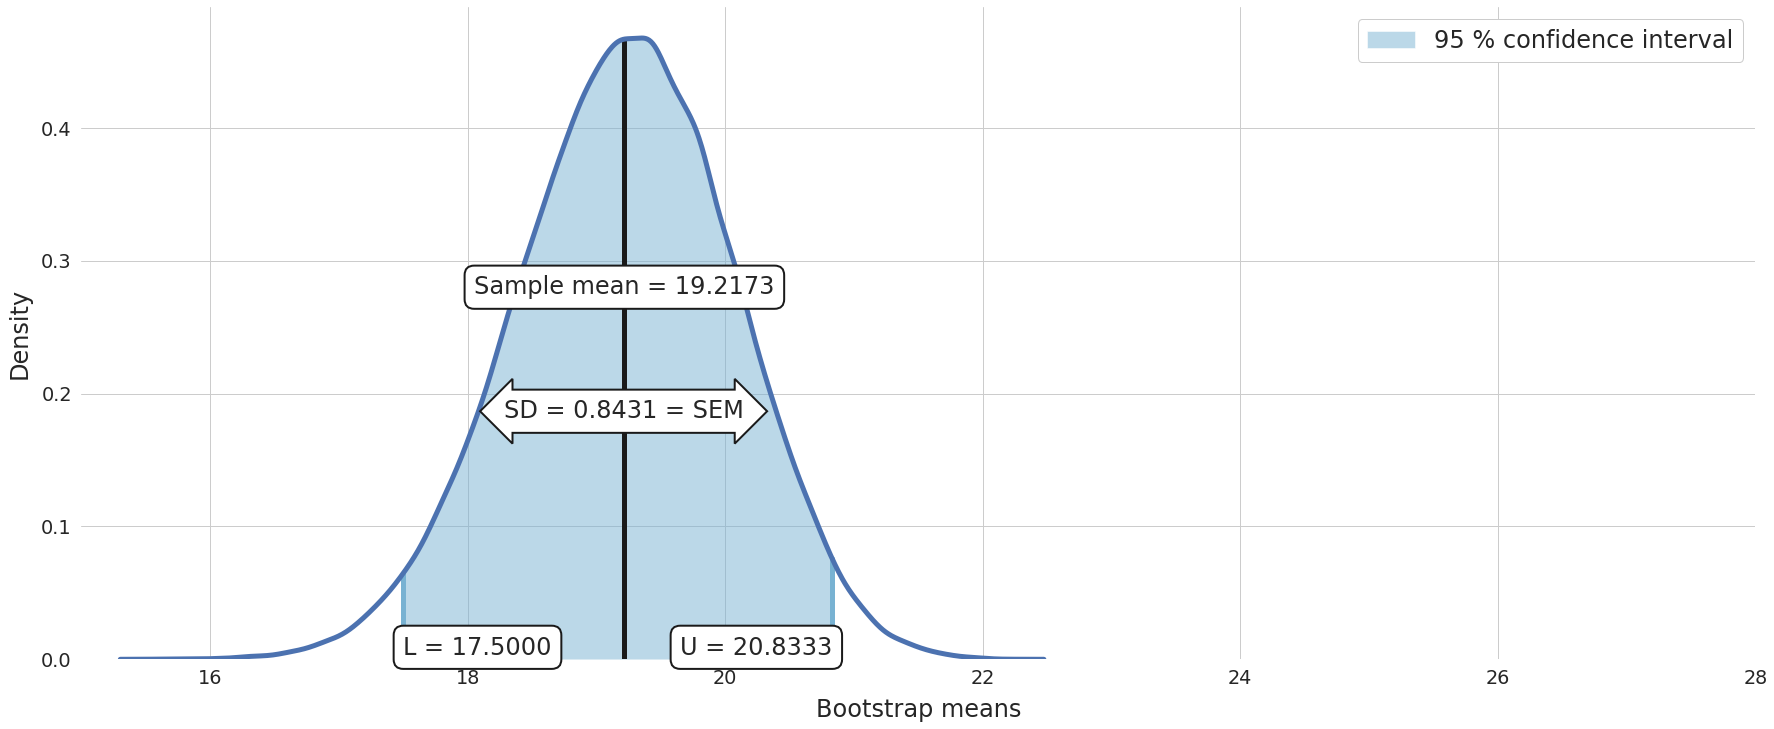

In [15]:
plot_bootstrap_distr(bs_means['water'], alpha=alpha, color_ci=color_cat1_light, 
                     null=None, color_pval=None, x_lim=[15., 28.], 
                     output_filename='./img/mosquitos_bootstrap_distr_water.png')

#### Bootstrap sample distribution of the mean difference between groups

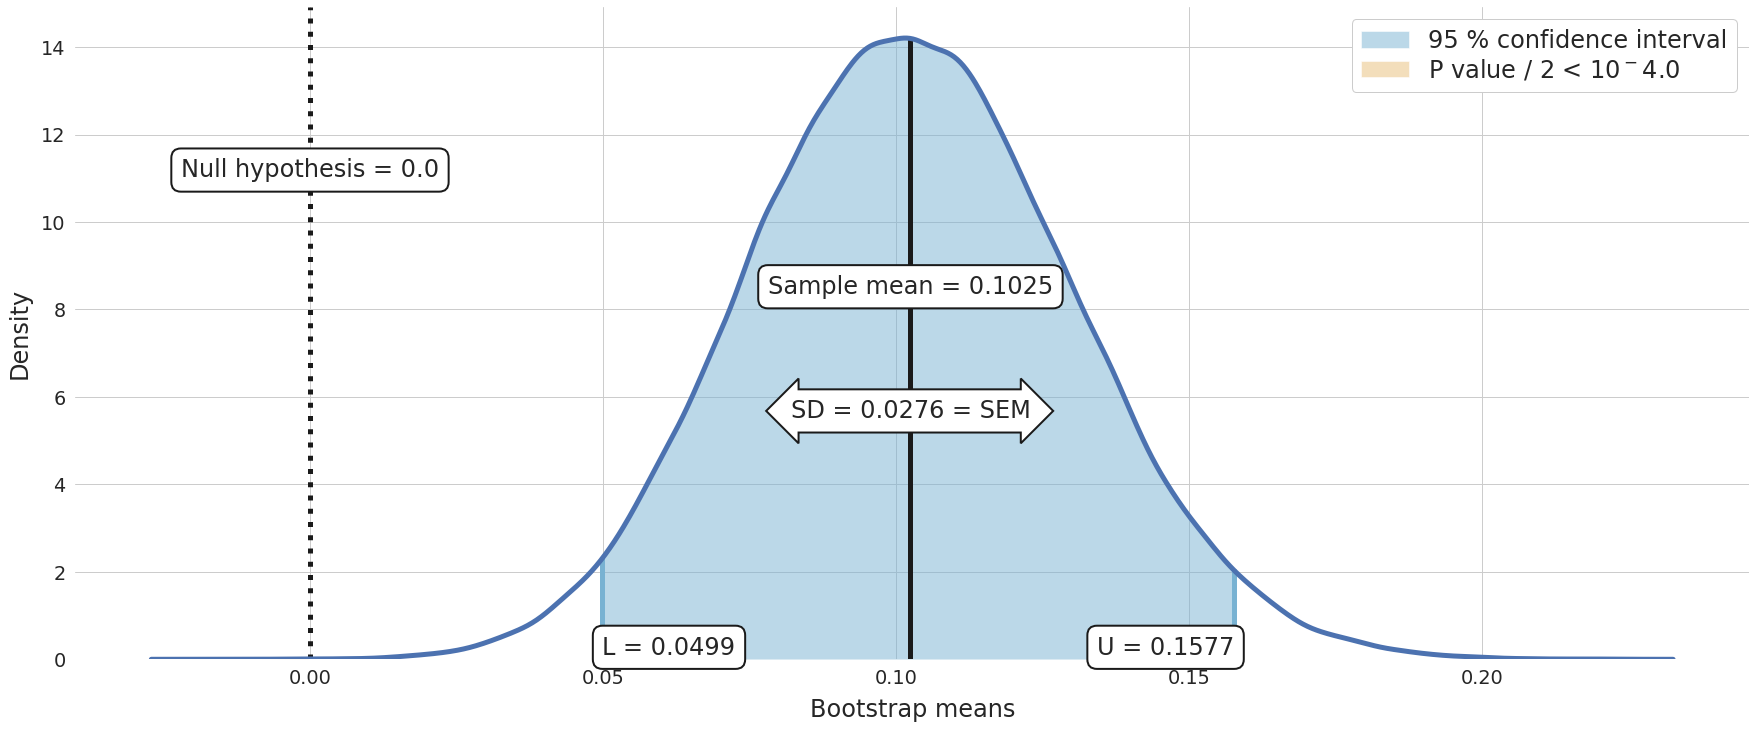

In [16]:
plot_bootstrap_distr(bs_norm_diff, alpha=alpha, color_ci=color_cat1_light, 
                     null=0., color_pval=color_cat2_light, 
                     output_filename='./img/mosquitos_bootstrap_distr_diff.png')